### Import libraries

In [5]:
import sys
sys.path.append("../")

In [6]:
import os
from os import environ
import numpy as np
from random import choices
import pandas as pd
from tqdm.notebook import tqdm

In [7]:
import skimage.io as io

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.transforms as mtrans
%matplotlib inline

In [9]:
from preprocess.common import load_nii

In [10]:
from utils.data_augmentation import data_augmentation_selector
from utils.dataload import *
from utils.training import *
from models import *

-----

In [11]:
in_channels = 1
train_aug, train_aug_img, val_aug = data_augmentation_selector("none", 224, 224)

Using None Data Augmentation


## Load Discriminator Model

In [12]:
num_classes, crop_size, model_name = 3, 224, "resnet34_unet_scratch_classification"

discriminator = model_selector(model_name, num_classes=num_classes, in_channels=in_channels)
model_total_params = sum(p.numel() for p in discriminator.parameters())
print("Model total number of parameters: {}".format(model_total_params))
discriminator = torch.nn.DataParallel(discriminator, device_ids=range(torch.cuda.device_count()))

model_checkpoint = "../evaluationSubmission/discriminator_v3.pt"
discriminator.load_state_dict(torch.load(model_checkpoint))
print("Discriminator checkpoint loaded correctly!")

Model total number of parameters: 35603483
Discriminator checkpoint loaded correctly!


#### Check performance

In [13]:
data_partition = "validation"
general_aug, img_aug = train_aug, train_aug_img
normalization = "standardize"
fold_system = "patient"
label_type = "vendor_label_full"
data_fold = 0
add_depth = False
data_fold_validation = None

accuracy_val_dataset = MMsDataset(
    mode=data_partition, transform=train_aug, img_transform=train_aug_img,
    folding_system=fold_system, normalization=normalization, label_type=label_type,
    train_fold=data_fold, val_fold=data_fold_validation, add_depth=add_depth
)

accuracy_loader = DataLoader(accuracy_val_dataset, batch_size=1, shuffle=False, drop_last=False)

In [14]:
criterion, weights_criterion = "ce", "default"
criterion, weights_criterion, multiclass_criterion = get_criterion(criterion, weights_criterion)
task = "classification"  # binary_classification or classification

accuracy, val_loss = val_step_accuracy(
   accuracy_loader, discriminator, criterion, weights_criterion, task=task
)

print(f"Discriminator accuracy: {accuracy}")

Discriminator accuracy: 1.0


## Load Data

In [15]:
data_partition = "train"
general_aug, img_aug = train_aug, train_aug_img
normalization = "none"
fold_system = "all"
label_type = "vendor_label_full"
add_depth = False
in_channels = 3 if add_depth else 1
data_fold_validation = None

discriminator_val_dataset = MMsDataset(
    mode=data_partition, transform=train_aug, img_transform=train_aug_img,
    folding_system=fold_system, normalization=normalization, label_type=label_type,
    add_depth=add_depth, get_id=True
)

discriminator_loader = DataLoader(discriminator_val_dataset, batch_size=1, shuffle=False, drop_last=False)


-------------------------
USING ALL DATA FOR TRAINING
-------------------------



## Entropy Image Modificator (Data Augmentation)

In [16]:
# Image modification using entropy
class ImageBackwardEntropy:

    def __init__(self, discriminator_model, target, max_iters=500, out_threshold=0.01, entropy_lambda=0.9,
                 add_l1=False, l1_lambda=0.0, add_blur_param=False, blur_lambda=0.0,
                 add_unblur_param=False, unblur_lambda=0.0, add_gamma_param=False, gamma_lambda=0.0, verbose=False):

        self.discriminator_model = discriminator_model
        self.target = target
        self.max_iters = max_iters
        self.out_threshold = out_threshold
        self.entropy_lambda = entropy_lambda
        self.verbose = verbose

        self.add_l1 = add_l1
        self.l1_lambda = l1_lambda

        self.add_blur_param = add_blur_param
        self.blur_lambda = blur_lambda

        self.add_unblur_param = add_unblur_param
        self.unblur_lambda = unblur_lambda

        self.add_gamma_param = add_gamma_param
        self.gamma_lambda = gamma_lambda

    @staticmethod
    def cxe_loss(predicted, real):
        # https://discuss.pytorch.org/t/catrogircal-cross-entropy-with-soft-classes/50871
        return -(real * torch.log(predicted)).sum(dim=1).mean()

    def apply(self, image, target=None):
        if target is None: target = self.target

        x = copy.deepcopy(image).detach()

        blur_param = torch.tensor(0.0, requires_grad=False)

        blurring_matrix = torch.tensor(
            [[blur_param, blur_param, blur_param],
             [blur_param, 1, blur_param],
             [blur_param, blur_param, blur_param]],
            requires_grad=False)

        unblur_param = torch.tensor(0.0, requires_grad=False)

        unblurring_matrix = torch.tensor(
            [[-unblur_param, -unblur_param, -unblur_param],
             [-unblur_param, 1 + 8 * unblur_param, -unblur_param],
             [-unblur_param, -unblur_param, -unblur_param]],
            requires_grad=False)

        gamma_param = torch.tensor(1.0, requires_grad=False).cuda()

        with torch.no_grad():
            x_ini = apply_batch_local_torch_normalization(copy.deepcopy(x).detach(), "standardize")
            initial_y = torch.nn.functional.softmax(self.discriminator_model(x_ini), dim=1)
        
        for iteration in range(self.max_iters):
            x.requires_grad_(True)
            # Apply blurring matrix conv2d
            if self.add_blur_param:
                blurring_matrix = blurring_matrix.detach()
                blur_sum = blurring_matrix.sum()
                blurring_matrix = blurring_matrix / blur_sum
                blurring_matrix.requires_grad_(True)
                x2 = torch.nn.functional.conv2d(
                    x, blurring_matrix.unsqueeze(0).unsqueeze(0).cuda(),
                    padding=1, stride=1
                )
            else:
                x2 = x

            # Apply unblurring matrix conv2d
            if self.add_unblur_param:
                unblurring_matrix = unblurring_matrix.detach()
                unblur_sum = unblurring_matrix.sum()
                unblurring_matrix = unblurring_matrix / unblur_sum
                unblurring_matrix.requires_grad_(True)
                x3 = torch.nn.functional.conv2d(
                    x2, unblurring_matrix.unsqueeze(0).unsqueeze(0).cuda(),
                    padding=1, stride=1
                ).clamp(0) + 1e-10
            else:
                x3 = x2

            # Gamma Correction => C = (Max*((Image/Max)^gammaFactor))
            if self.add_gamma_param:
                gamma_param = gamma_param.detach()
                gamma_param.requires_grad_(True)
                x4 = x3.max().detach() * (torch.pow(x3 / (x3.max().detach()), gamma_param))
            else:
                x4 = x3

            x5 = apply_batch_local_torch_normalization(x4, "standardize")

            y = torch.nn.functional.softmax(self.discriminator_model(x5), dim=1)

            # Check if difference is too small => Break
            if (y.cuda() - target.cuda()).abs().max() <= self.out_threshold:
                x.requires_grad_(False)
                break

            error = self.cxe_loss(y.cuda(), target.cuda())

            if self.add_l1:  # ToDo: no seria x5? las primeras veces image===x
                error = error - (torch.nn.L1Loss()(image.detach(), x) * self.l1_lambda)

            error.backward()

            if self.add_blur_param:
                blur_param_grad = (blurring_matrix.grad.sum() - blurring_matrix.grad[1, 1]) / blur_sum
                blur_param = blur_param - self.blur_lambda * blur_param_grad
                blur_param = torch.clamp(blur_param, 0, 1)
                blurring_matrix = torch.tensor(
                    [[blur_param, blur_param, blur_param],
                     [blur_param, 1, blur_param],
                     [blur_param, blur_param, blur_param]],
                    requires_grad=False)
                blurring_matrix /= blurring_matrix.sum()

            if self.add_unblur_param:
                unblur_param_grad = (-unblurring_matrix.grad.sum() + (9 * unblurring_matrix.grad[1, 1])) / unblur_sum
                unblur_param = unblur_param - self.unblur_lambda * unblur_param_grad
                unblur_param = torch.clamp(unblur_param, 0, 0.15)
                unblurring_matrix = torch.tensor(
                    [[-unblur_param, -unblur_param, -unblur_param],
                     [-unblur_param, 1 + 8 * unblur_param, -unblur_param],
                     [-unblur_param, -unblur_param, -unblur_param]],
                    requires_grad=False)

            if self.add_gamma_param:
                gamma_param = (gamma_param.detach() - self.gamma_lambda * gamma_param.grad).clamp(0.8, 1.2)

            x = (x.detach() - self.entropy_lambda * x.grad).clamp(0)

        if self.verbose:
            print("")
            print(f"----- Stopping at iteration {iteration} -----")
            if self.add_blur_param:
                print("Blur matrix: \n{}".format(blurring_matrix))
            if self.add_unblur_param:
                print("Unblur matrix: \n{}".format(unblurring_matrix))
            if self.add_gamma_param:
                print("Gamma param: {}".format(gamma_param))
            print("Target: {}".format(target))
            print("Initial y: {}".format(['%.4f' % elem for elem in initial_y.tolist()[0]]))
            print("Final y: {}".format(['%.4f' % elem for elem in y.tolist()[0]]))
            print("")

        return x.detach(), x5.detach(), initial_y, y

In [107]:
class arguments:
    def __init__(self, target, out_threshold, entropy_lambda, max_iters, add_l1, l1_lambda,
                 add_blur_param, blur_lambda, add_unblur_param, unblur_lambda, 
                 add_gamma_param, gamma_lambda, verbose):
        self.target = target
        self.out_threshold = out_threshold
        self.entropy_lambda = entropy_lambda
        self.max_iters = max_iters
        
        self.add_l1 = add_l1; self.l1_lambda = l1_lambda
        self.add_blur_param = add_blur_param; self.blur_lambda = blur_lambda
        self.add_unblur_param = add_unblur_param; self.unblur_lambda = unblur_lambda
        self.add_gamma_param = add_gamma_param; self.gamma_lambda = gamma_lambda
        
        self.verbose = verbose
        

args = arguments(target="A", out_threshold=0.05, entropy_lambda=2, max_iters=350, add_l1=False, l1_lambda=0,
                add_blur_param=True, blur_lambda=0.01, add_unblur_param=True, unblur_lambda=0.01, 
                add_gamma_param=True, gamma_lambda=0.01, verbose=False)

In [108]:
def target_generator(target):
    if target == 'A':
        target_tensor = torch.from_numpy(np.array([1.0, 0.0, 0.0]))
    elif target == 'B':
        target_tensor = torch.from_numpy(np.array([0.0, 1.0, 0.0]))
    elif target == 'C':
        target_tensor = torch.from_numpy(np.array([0.0, 0.0, 1.0]))
    elif target == 'equal':
        target_tensor = torch.from_numpy(np.array([0.333, 0.333, 0.333]))
    else:
        assert False, "Unknown target '{}'".format(args.target)
    return target_tensor

In [109]:
target = target_generator("equal")

In [110]:
entropy_descriptor = ""  # "simple/"

save_dir = "entropy_images/{}outThreshold{}_learningRate{}_maxIters{}_target{}".format(
    entropy_descriptor, args.out_threshold, args.entropy_lambda, args.max_iters, args.target
)

if args.add_l1: save_dir += "_usingL1lambda{}".format(args.l1_lambda)
if args.add_blur_param: save_dir += "_usingBlurParamlambda{}".format(args.blur_lambda)
if args.add_unblur_param: save_dir += "_usingUnblurParamlambda{}".format(args.unblur_lambda)
if args.add_gamma_param: save_dir += "_usingGammaParamlambda{}".format(args.gamma_lambda)

In [111]:
image_modificator_fn = ImageBackwardEntropy(
    discriminator, target, max_iters=args.max_iters,
    out_threshold=args.out_threshold, entropy_lambda=args.entropy_lambda, verbose=args.verbose,
    add_l1=args.add_l1, l1_lambda=args.l1_lambda, add_blur_param=args.add_blur_param, blur_lambda=args.blur_lambda,
    add_unblur_param=args.add_unblur_param, unblur_lambda=args.unblur_lambda,
    add_gamma_param=args.add_gamma_param, gamma_lambda=args.gamma_lambda,
)

## Generator

In [112]:
train_csv = pd.read_csv("../utils/data/train.csv")

In [113]:
opposite_targets = {"A":["B", "C", "equal"], "B":["A", "C", "equal"], "C":["A", "B", "equal"]}

In [114]:
base_dir = MMs_DATA_PATH = os.environ.get('MMsCardiac_DATA_PATH')
save_dir = os.path.join(base_dir, "Entropy-samples")
os.makedirs(save_dir, exist_ok=True)

In [115]:
res = []

In [116]:
from tqdm.notebook import tqdm

In [118]:
for sample_indx, (image, vendor_label, original_image, img_id) in enumerate(tqdm(discriminator_loader)):
    image = image.type(torch.float).cuda()
    c_patient = img_id[0].split("_")[0]
    c_vendor = train_csv.loc[train_csv["External code"] == c_patient].iloc[0]["Vendor"]
    
    original_img = copy.deepcopy(image).detach()
    
    if c_vendor=="A":
        for opposite in opposite_targets[c_vendor]:

            image_fn, image_fn_normalized, init_discriminator_probs, new_discriminator_probs = image_modificator_fn.apply(image, target_generator(opposite))

            np.save(os.path.join(
                save_dir, "{}_{}to{}_standardized.npy".format(img_id[0], c_vendor, opposite.capitalize())
            ), image_fn.squeeze().cpu().numpy())

            res.append({
                "External code": img_id[0][:6], "Slice": int(img_id[0][12]), "Phase": int(img_id[0][-1]),
                "VendorInit": c_vendor, "VendorTarget": opposite,
                "InitProbs": ["{:.3f}".format(prob) for prob in init_discriminator_probs.tolist()[0]],
                "NewProbs": ["{:.3f}".format(prob) for prob in new_discriminator_probs.tolist()[0]]}
            )

KeyboardInterrupt: 

In [120]:
df = pd.DataFrame(res)
df

,External code,Slice,Phase,VendorInit,VendorTarget,InitProbs,NewProbs
0,A0S9V9,0,0,A,B,"[1.000, 0.000, 0.000]","[0.005, 0.994, 0.000]"
1,A0S9V9,0,0,A,C,"[1.000, 0.000, 0.000]","[0.048, 0.000, 0.952]"
2,A0S9V9,0,0,A,equal,"[1.000, 0.000, 0.000]","[0.286, 0.379, 0.335]"
3,A0S9V9,0,0,A,B,"[1.000, 0.000, 0.000]","[0.005, 0.994, 0.000]"
4,A0S9V9,0,0,A,C,"[1.000, 0.000, 0.000]","[0.048, 0.000, 0.952]"
...,...,...,...,...,...,...,...
379,A3H1O5,1,0,A,C,"[1.000, 0.000, 0.000]","[0.050, 0.000, 0.950]"
380,A3H1O5,1,0,A,equal,"[1.000, 0.000, 0.000]","[0.383, 0.304, 0.314]"
381,A3H1O5,2,0,A,B,"[1.000, 0.000, 0.000]","[0.048, 0.951, 0.001]"
382,A3H1O5,2,0,A,C,"[1.000, 0.000, 0.000]","[0.047, 0.000, 0.953]"


In [121]:
df.to_csv("entropy_dataset.csv", index=False)

In [102]:
original_img_np = original_img.cpu().detach().squeeze(0).squeeze(0)
image_fn_np = image_fn.cpu().detach().squeeze(0).squeeze(0)

diferencia_np = original_img_np-image_fn_np

Text(0.5, 0.98, 'Histogram Study')

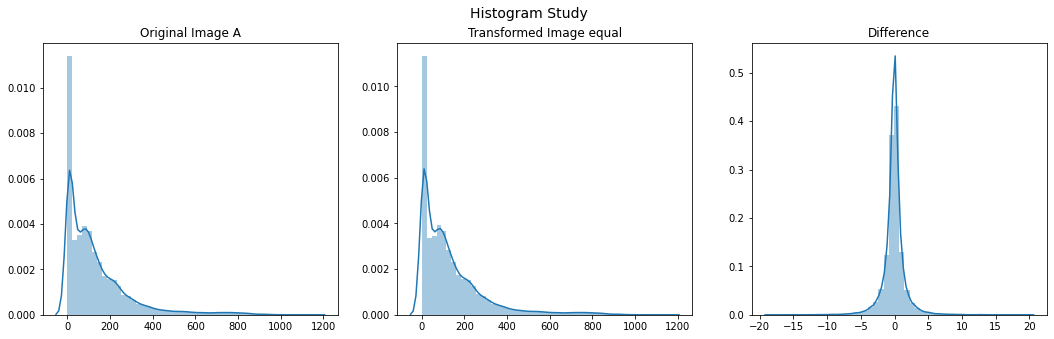

In [103]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
#ax1.axis('off'); ax2.axis('off'); ax3.axis('off')

ax1.set_title(f"Original Image {c_vendor}")
sns.distplot(original_img_np, ax=ax1)
ax2.set_title(f"Transformed Image {opposite}")
sns.distplot(image_fn_np, ax=ax2)
ax3.set_title("Difference")
sns.distplot(diferencia_np, ax=ax3)

plt.suptitle("Histogram Study", fontsize=14)

In [104]:
image_fn_normalized.squeeze(0).squeeze(0).shape

torch.Size([224, 224])

'\nos.makedirs(save_dir, exist_ok=True)\nplt.savefig(\n    os.path.join(save_dir, "{}_{}.jpg".format(img_id_str, str(uuid.uuid4().hex))),\n    dpi=200, pad_inches=0.2, bbox_inches=\'tight\'\n)\nplt.close()\n'

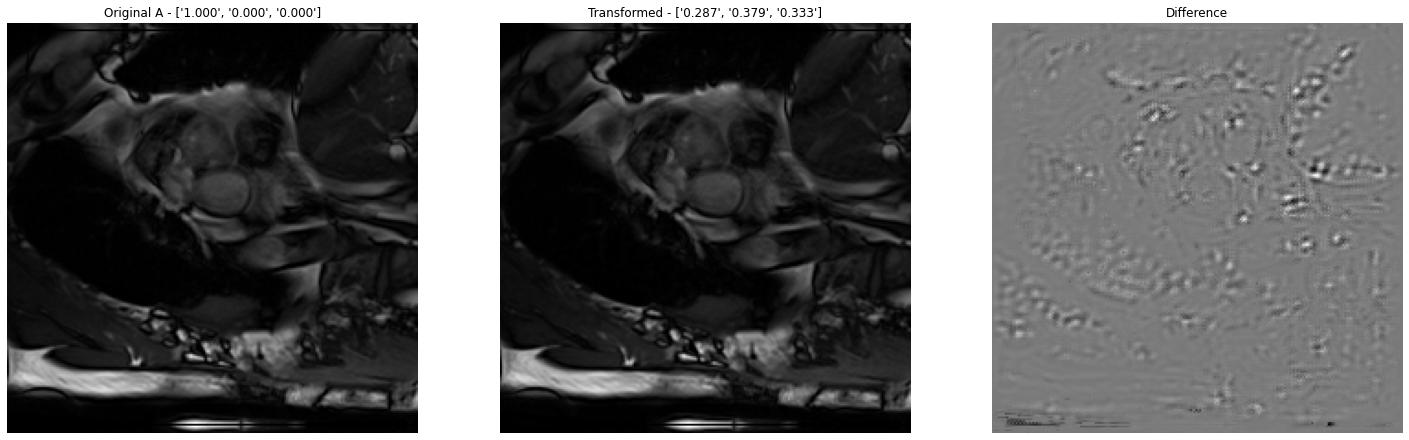

In [105]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 40))

ax1.set_title("Original {} - {}".format(c_vendor, ['%.3f' % elem for elem in init_discriminator_probs.tolist()[0]]))
ax1.imshow(original_img_np, cmap="gray")
ax1.axis("off")

ax2.set_title("Transformed - {}".format(['%.3f' % elem for elem in new_discriminator_probs.tolist()[0]]))
ax2.imshow(image_fn_np, cmap="gray")
ax2.axis("off")

ax3.set_title("Difference")
ax3.imshow(diferencia_np, cmap="gray")
ax3.axis("off")

"""
os.makedirs(save_dir, exist_ok=True)
plt.savefig(
    os.path.join(save_dir, "{}_{}.jpg".format(img_id_str, str(uuid.uuid4().hex))),
    dpi=200, pad_inches=0.2, bbox_inches='tight'
)
plt.close()
"""